In [1]:
import math
import random
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import matplotlib.pyplot as plt
import scipy.integrate as si
from scipy.integrate import tplquad,dblquad,quad
from scipy.stats import norm, uniform
from scipy.optimize import minimize
from scipy.linalg import fractional_matrix_power
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
import cmasher as cmr

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
import torch.optim as optim  
import torch.distributions as dist  

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')

from thop import profile
from torch.autograd.functional import jacobian

In [2]:
def EI_calculate_pdet(A, Sigma):
    """
    Calculate the Effective Information (EI) based on the pseudo-determinant.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    
    Returns:
    float: The logarithm of the pseudo-determinant (EI).
    """
    n = A.shape[1]
    # Compute the SVD of A^T * Sigma^-1 * A, and return the product of singular values greater than 1e-10
    _, s, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    pseudo_det = np.sum(np.log(s[s > 1e-10]))  # Only consider non-zero singular values
    
    # Effective Information (EI) is the log of the pseudo-determinant scaled by constants
    EI = pseudo_det/2-np.log((2 * np.pi * np.e)**(n / 2))
    
    return EI


def EI_calculate_m_star(A, Sigma, k):
    """
    Calculate the maximum Effective Information (max EI) using the first k singular values.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    k (int): The number of singular values to consider.
    
    Returns:
    float: The logarithm of the pseudo-determinant using the top k singular values (max EI).
    """
    n = A.shape[1]
    # Compute the SVD of A^T * Sigma^-1 * A, and take the product of the first k singular values
    _, s, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    max_pseudo_det = np.sum(np.log(s[:k]))
    
    # max EI is the log of the top k singular values' product, scaled by constants
    max_EI = max_pseudo_det/2-np.log((2 * np.pi * np.e)**(k / 2))
    
    return max_EI

def Gamma(alpha, r_eps, A, Sigma):
    """
    Calculate the Gamma function based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r_eps (int): The number of singular values to consider.
    A (ndarray): Input matrix A, of size n x n.
    Sigma (ndarray): Input matrix Sigma, of size n x n.
    
    Returns:
    float: The computed Gamma value.
    """
    n = A.shape[1]
    
    # Compute the SVD of A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Compute the SVD of Sigma
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    gamma_value = (2 * np.pi / alpha)**(n / 2) * \
                  np.prod(s_AS2[:r_eps])**(1 / 2 - alpha / 4) * \
                  np.prod(s_S2[:r_eps])**(alpha / 4)
    
    return gamma_value

def gamma_0(alpha, r, A, Sigma):
    """
    Calculate gamma_0 based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r (int): The number of singular values to consider.
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    float: The computed gamma_0 value.
    """
    n = A.shape[1]
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Perform SVD on Sigma^-1
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    # Compute gamma_0 using the top r singular values
    gamma_0_value = np.sum(np.log(s_AS2[:r]))*(1 / 2 - alpha / 4) + np.sum(np.log(s_S2[:n]))*(alpha / 4)
    
    return gamma_0_value


def gamma(alpha, r_eps, A, Sigma):
    """
    Calculate gamma based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r_eps (int): The number of singular values to consider.
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    float: The computed gamma value.
    """
    n = A.shape[1]
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Perform SVD on Sigma^-1
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    # Compute gamma using the top r_eps singular values
  
    gamma_value = np.sum(np.log(s_AS2[:r_eps]))*(1 / 2 - alpha / 4) + np.sum(np.log(s_S2[:r_eps]))*(alpha / 4)
    
    return gamma_value


def calculate_threshold(A, Sigma):
    """
    Calculate the threshold based on the singular values of A^T * Sigma^-1 * A.
    
    Parameters:
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    tuple: The threshold value and its corresponding index.
    """
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    
    # Compute the differences between consecutive singular values
    diff = np.diff(s_AS2)
    
    # Compute the ratio of consecutive singular values to avoid division by zero
    ratio = s_AS2[:-1] / s_AS2[1:]  # Element-wise division
    
    # Find the index of the maximum product of difference and ratio
    max_diff_index = np.argmax(np.abs(diff) * np.abs(ratio))
    
    # Return the threshold value and the index (index is adjusted by +1)
    return s_AS2[max_diff_index + 1], max_diff_index + 1

In [3]:
def clear_causal_emergence(A, Sigma):
    """
    Calculate the causal emergence based on changes in effective information (EI) and gamma values.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    
    Returns:
    tuple: Delta_J_R and Delta_Gamma_0 values representing causal emergence.
    """
    n = A.shape[1]
    
    # Calculate the rank of A^T * Sigma^-1 * A
    rk = np.linalg.matrix_rank(A.T @ np.linalg.inv(Sigma) @ A)

    # Calculate the change in effective information (Delta_J_R)
    Delta_J_R = (EI_calculate_m_star(A, Sigma, rk) / rk) - (EI_calculate_pdet(A, Sigma) / n)
    
    # Calculate the change in gamma values (Delta_Gamma_0)
    Delta_Gamma_0 = (gamma(1, rk, A, Sigma) / rk) - (gamma_0(1, rk, A, Sigma) / n)
    
    return Delta_J_R, Delta_Gamma_0

def vague_causal_emergence(A, Sigma):
    """
    Calculate the vague causal emergence based on the threshold calculation for causal emergence.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    
    Returns:
    tuple: Delta_J and Delta_Gamma_eps values representing vague causal emergence.
    """
    n = A.shape[1]

    epsilon, rk_eps = calculate_threshold(A, Sigma)  # Get threshold epsilon and rk_eps
    
    # Calculate the change in Effective Information (Delta_J)
    Delta_J = (EI_calculate_m_star(A, Sigma, rk_eps) / rk_eps) - (EI_calculate_pdet(A, Sigma) / n)
    
    # Calculate the change in gamma values (Delta_Gamma_eps)
    Delta_Gamma_eps = (gamma(1, rk_eps, A, Sigma) / rk_eps) - (gamma(1, n, A, Sigma) / n)
    
    return Delta_J, Delta_Gamma_eps


def vague_causal_emergence_customize(A, Sigma, rk_eps):
    """
    Calculate the customized vague causal emergence based on a given rk_eps.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    rk_eps (int): The rank parameter for customized calculation.
    
    Returns:
    tuple: Delta_J and Delta_Gamma_eps values representing customized vague causal emergence.
    """
    n = A.shape[0]

    # Calculate the change in Effective Information (Delta_J)
    Delta_J = (EI_calculate_m_star(A, Sigma, rk_eps) / rk_eps) - (EI_calculate_pdet(A, Sigma) / n)
    
    # Calculate the change in gamma values (Delta_Gamma_eps)
    Delta_Gamma_eps = (gamma(1, rk_eps, A, Sigma) / rk_eps) - (gamma(1, n, A, Sigma) / n)
    
    return Delta_J, Delta_Gamma_eps

def create_block_diagonal_matrix(matrix1, matrix2):
    if matrix1.ndim != 2 or matrix2.ndim != 2:
        raise ValueError("The input matrix must be two-dimensional.")
    if matrix1.shape[0] != matrix1.shape[1] or matrix2.shape[0] != matrix2.shape[1]:
        raise ValueError("The input matrix must be a square matrix.")
    n1 = matrix1.shape[0]
    n2 = matrix2.shape[0]
    result_dim = n1 + n2
    result = np.zeros((result_dim, result_dim), dtype=matrix1.dtype)
    result[:n1, :n1] = matrix1
    result[n1:, n1:] = matrix2
    return result

# Example Growth Model

clear causal emergence

Text(0, 0.5, '$x$')

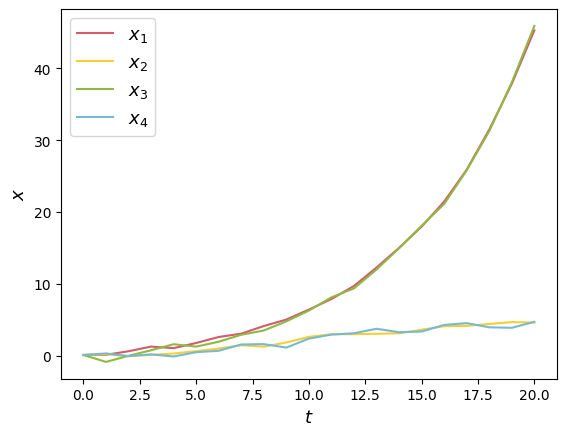

In [4]:
A= np.array( 
[[1.2,0,0,0],
 [0,1.05,0,0],
 [1.20,0,0,0],
 [0,1.05,0,0]]
)

n=4
T=20

sig=0.1
Sigma=np.diag([sig for i in range(n)])

X=np.zeros([n,T+1])
e=np.zeros([n,T+1])
X[:,0]=0.1
for t in range(1,T+1):
    e[:,t]=np.random.multivariate_normal(np.zeros(Sigma.shape[0]),Sigma,1)
    X[:,t]=A@X[:,t-1]+e[:,t]

colors = ['#8386A8','#D15C6B','#F5CF36','#8FB943','#78B9D2','#413123']
for i in range(n):
    plt.plot(range(T+1),X[i,:],label='$x_%s$'%(i+1),color=colors[i+1])
plt.legend(fontsize=13)
plt.xlabel('$t$',fontsize=13)
plt.ylabel('$x$',fontsize=13)

In [5]:
def gaussian_kernel(pairwise_diff, sigma=1.0):
    # pairwise_diff 的形状: (n, m, d)
    return torch.exp(-torch.norm(pairwise_diff, p=2, dim=2)**2 / (2 * sigma**2))

# 定义计算 G_xx 和 G_yx 的函数
def compute_G_matrix_vectorized(X, Y, kernel, sigma=1.0):
    # 计算 G_xx
    X_pairwise_diff = X.unsqueeze(1) - X.unsqueeze(0)  # 形状: (n, n, d)
    G_xx = kernel(X_pairwise_diff, sigma=sigma)
    
    # 计算 G_yx
    Y_X_pairwise_diff = Y.unsqueeze(1) - X.unsqueeze(0)  # 形状: (n, n, d)
    G_yx = kernel(Y_X_pairwise_diff, sigma=sigma)
    
    return G_xx, G_yx

# 示例数据
X_tensor = torch.tensor(X.T[:20])
Y_tensor = torch.tensor(X.T[1:])

# 计算 G_xx 和 G_yx
G_xx, G_yx = compute_G_matrix_vectorized(X_tensor, Y_tensor, gaussian_kernel, sigma=1.0)

Koopman_G = torch.linalg.inv(G_xx)@G_yx
Koopman_G 

print("G_xx^-1G_yx:")
print(Koopman_G )

G_xx^-1G_yx:
tensor([[ 6.3582e-01,  3.2081e+00, -2.3563e-01, -2.9823e+00, -1.7359e+00,
         -2.2340e+00, -6.3296e-01, -1.0222e-02,  5.4935e-03,  2.9576e-03,
         -7.0955e-04, -1.0098e-05,  1.3602e-06,  1.5966e-07, -1.1279e-10,
          2.8316e-14, -2.8386e-18,  4.4843e-23, -3.7836e-32,  1.8861e-45],
        [ 8.8865e-01,  1.9713e-01,  1.0927e+00,  5.7766e-01,  5.2216e-01,
          2.6911e-03, -2.7268e-01, -1.3238e-02,  5.9400e-03,  4.1624e-03,
         -9.9637e-04, -1.4266e-05,  1.9152e-06,  2.2481e-07, -1.5881e-10,
          3.9871e-14, -3.9969e-18,  6.3143e-23, -5.3275e-32,  2.6558e-45],
        [-8.9584e-01, -3.0250e+00,  4.0700e-02,  3.3550e+00,  1.0015e+00,
          2.9832e+00,  1.6214e+00,  4.2372e-02, -2.7071e-02, -1.7081e-02,
          4.0934e-03,  5.8472e-05, -7.8601e-06, -9.2263e-07,  6.5176e-10,
         -1.6363e-13,  1.6403e-17, -2.5914e-22,  2.1864e-31, -1.0899e-44],
        [ 5.7318e-01,  7.8116e-01,  2.2011e-01, -5.9232e-01,  1.6694e+00,
         -1.5258e+00, 

In [6]:
U,S,V = torch.linalg.svd(Koopman_G)
S

tensor([8.2088e+00, 4.2985e+00, 1.6168e+00, 1.4902e+00, 1.1074e+00, 1.0995e+00,
        1.0004e+00, 1.0001e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 9.9997e-01,
        9.9972e-01, 9.4909e-01, 9.1160e-01, 8.4715e-01, 7.4691e-01, 4.9360e-01,
        1.9110e-01, 1.2530e-73], dtype=torch.float64)

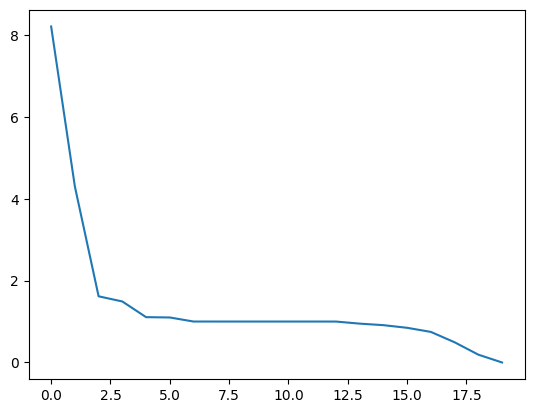

In [7]:
plt.plot(S)

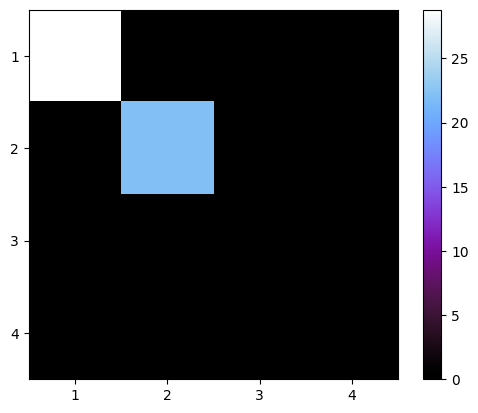

In [8]:
plt.imshow(A.T@np.linalg.inv(Sigma)@A,cmap = "cmr.voltage")
#c=plt.colorbar(plt.imshow(A@np.linalg.inv(A.T@np.linalg.inv(Sigma)@A)),cmap = "cmr.freeze",label='$A^T\Sigma^{-1}A$')
plt.xticks(np.arange(4), np.arange(1, 5))
plt.yticks(np.arange(4), np.arange(1, 5))
plt.colorbar()

Text(0, 0.5, '$s_{A^T\\Sigma^{-1}A}$')

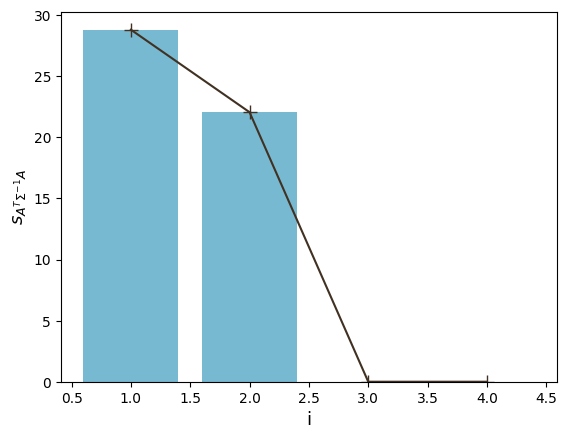

In [9]:
_,S,_ = np.linalg.svd(A.T@np.linalg.inv(Sigma)@A)
plt.bar([1,2,3,4],S,color = colors[4])
plt.plot([1,2,3,4],S,color = colors[5],marker ='+',markersize =10)
plt.xlabel('i',fontsize=13)
plt.ylabel('$s_{A^T\Sigma^{-1}A}$',fontsize=13)
#plt.hlines(2,0.5,8.5,linestyles='--')

In [10]:
Delta_J_R, Delta_Gamma_0 = clear_causal_emergence(A,Sigma)
print(Delta_J_R, Delta_Gamma_0)

0.8067109986293444 0.4033554993146721


In [11]:
rk=2

In [12]:
EI_calculate_m_star(A, Sigma, rk)/rk, (EI_calculate_pdet(A, Sigma) / n),(gamma(1, rk, A, Sigma) / rk),(gamma_0(1, rk, A, Sigma) / n)

(0.19448346405401606,
 -0.6122275345753283,
 1.3823572718778556,
 0.9790017725631835)

vague causal emergence

Text(0, 0.5, '$x$')

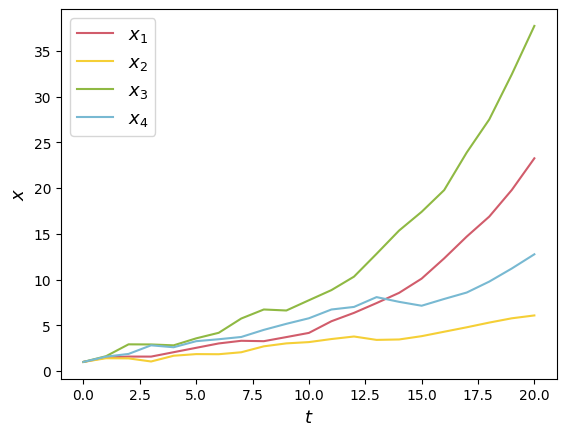

In [13]:
A= np.array( 
[[1.2,0.00,0.00,0],
 [0.00,1.05,0.001,0],
 [1.22,0.00,0.4,0.1],
 [0,1.06,0.03,0.5]]
)

n=4
T=20

sig=0.1
Sigma=np.diag([sig for i in range(n)])

X=np.zeros([n,T+1])
e=np.zeros([n,T+1])
X[:,0]=1
for t in range(1,T+1):
    e[:,t]=np.random.multivariate_normal(np.zeros(Sigma.shape[0]),Sigma,1)
    X[:,t]=A@X[:,t-1]+e[:,t]

c=['darkred','darkblue','darkgreen','darkorange']
for i in range(n):
    plt.plot(range(T+1),X[i,:],label='$x_%s$'%(i+1),color=colors[i+1])
plt.legend(fontsize=13)
plt.xlabel('$t$',fontsize=13)
plt.ylabel('$x$',fontsize=13)

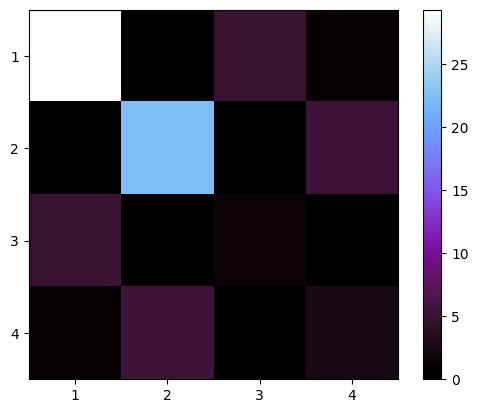

In [14]:
plt.imshow(A.T@np.linalg.inv(Sigma)@A,cmap = "cmr.voltage")
#c=plt.colorbar(plt.imshow(A@np.linalg.inv(A.T@np.linalg.inv(Sigma)@A)),cmap = "cmr.freeze",label='$A^T\Sigma^{-1}A$')
plt.xticks(np.arange(4), np.arange(1, 5))
plt.yticks(np.arange(4), np.arange(1, 5))
plt.colorbar()

In [15]:
Delta_J_R, Delta_Gamma_0 = clear_causal_emergence(A,Sigma)
print(Delta_J_R, Delta_Gamma_0)

0.0 0.0


In [16]:
Delta_J, Delta_Gamma_eps = vague_causal_emergence_customize(A,Sigma,2)
print(Delta_J, Delta_Gamma_eps)

0.8389961854605913 0.4194980927302956


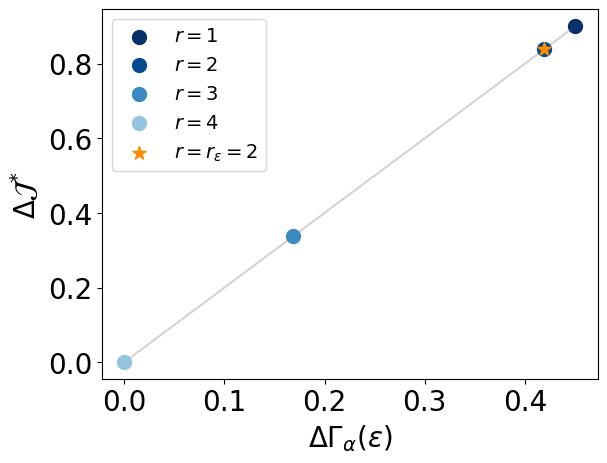

In [17]:
cmap = plt.get_cmap('Blues_r')
# 根据纵坐标设置颜色

n = 4
rs = [1,2,3,4]

color_map = cmap(-0.4+np.array(rs)/4)
EIs = []
Gammas = []
rks = []
for rk in rs:
    Gammas.append(gamma(1,rk,A,Sigma)/rk-gamma(1,n,A,Sigma)/n)
    EIs.append(EI_calculate_m_star(A,Sigma,rk)/rk-EI_calculate_pdet(A,Sigma)/n)
    rks.append(rk)

plt.plot(Gammas,EIs,color='lightgrey',zorder=1)
for rk in rs:  
    plt.scatter(Gammas[rk-1],EIs[rk-1],label='$r=%s$'%rk,color=color_map[rk-1],s=100,zorder=2)
plt.scatter(Gammas[1],EIs[1],label='$r=r_\epsilon=2$',color='darkorange',marker = '*',s=100,zorder=2)
plt.ylabel('$\Delta\mathcal{J}^{*}$',fontsize=20)
plt.xlabel('$\Delta\Gamma_\\alpha(\epsilon)}$',fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig('./Figure/Growth_rstar_eps.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

In [18]:
EIs[1]/Gammas[1]

2.0000000000000004

# Kuramoto Model

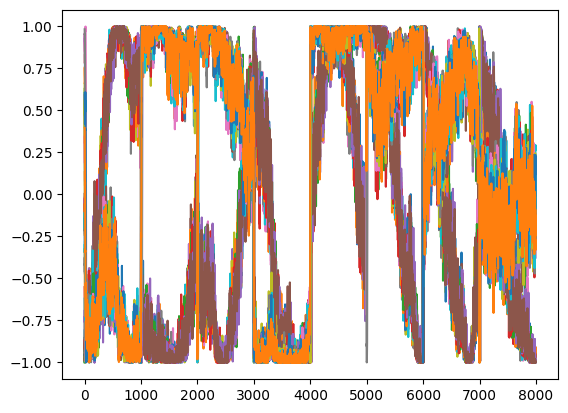

In [4]:
datas = np.load('../dataset/Kuramoto/train_sz32_g2_bs8.npy',allow_pickle=True)
datas_reshape = datas.item()['input'].reshape(datas.item()['input'].shape[0],datas.item()['input'].shape[-1])
for i in range(datas.item()['input'].shape[-1]):
    plt.plot(datas_reshape[:,i])

In [5]:
A = np.load('../results/jacobian/long_term_forecast_Kuramoto_NN_Kuramoto_ft-1_sl1_pl1_dm128_nh8_el2_dl1_df2048_fc1_flocnormal_dtTrue_Exp_0/jac_2510.npy')
L = np.load('../results/cov_L/long_term_forecast_Kuramoto_NN_Kuramoto_ft-1_sl1_pl1_dm128_nh8_el2_dl1_df2048_fc1_flocnormal_dtTrue_Exp_0/L_2510.npy')

In [6]:
n = A.shape[0]
L_diag = np.diag(L)
Sigma = L_diag
Sigma_inv_b = A.T @ np.linalg.inv(Sigma) @ A
Sigma_inv_f = np.linalg.inv(Sigma)
Sigma_inv_b_tensor = torch.tensor(Sigma_inv_b,device=device)
Sigma_inv_f_tensor = torch.tensor(Sigma_inv_f,device=device)

U, s_AS2, _ = torch.svd(Sigma_inv_b_tensor)
# Perform SVD on Sigma^-1
V, s_S2, _ = torch.svd(Sigma_inv_f_tensor)

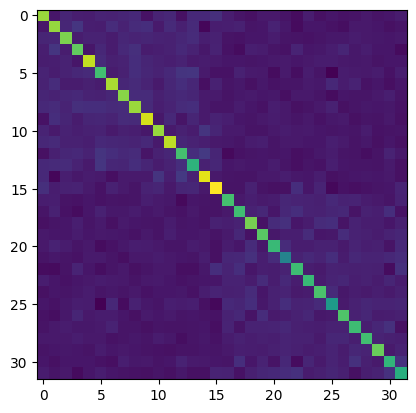

In [11]:
plt.imshow(Sigma_inv_b)

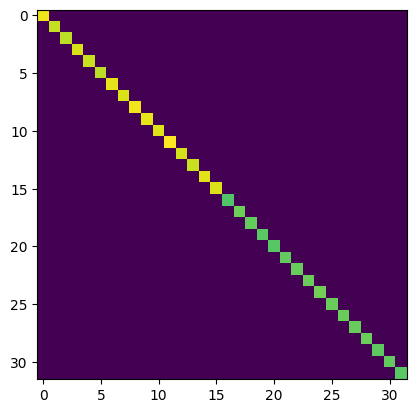

In [12]:
plt.imshow(Sigma_inv_f)

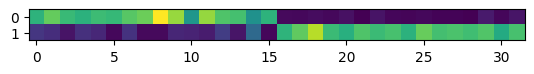

In [10]:
plt.imshow(abs(U[:,:2].T.cpu().numpy()))

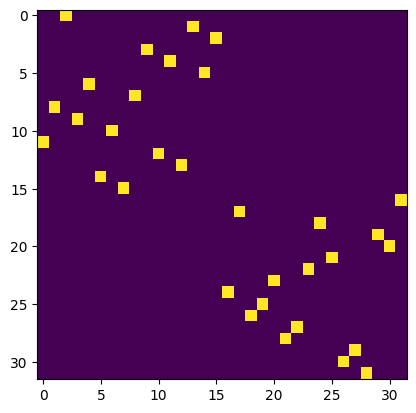

In [9]:
plt.imshow(V.cpu().numpy())

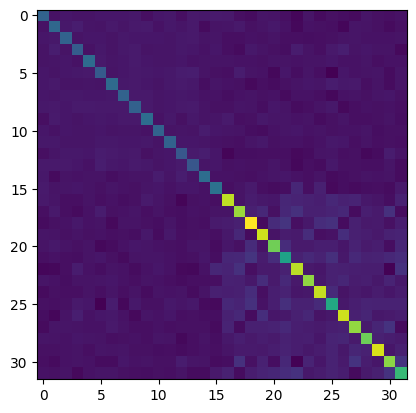

In [61]:
plt.imshow(Sigma_inv_b)

In [62]:
alpha = 1
r_eps = 2
gamma_M = torch.sum(torch.log(s_AS2[:r_eps]))*(1 / 2 - alpha / 4) + torch.sum(torch.log(s_S2[:r_eps]))*(alpha / 4)
gamma = torch.sum(torch.log(s_AS2))*(1 / 2 - alpha / 4) + torch.sum(torch.log(s_S2))*(alpha / 4)
Delta_gamma = gamma_M/r_eps - gamma/n
print(Delta_gamma, gamma_M/r_eps, gamma/n)

tensor(0.4013, device='cuda:0', dtype=torch.float64) tensor(3.0906, device='cuda:0', dtype=torch.float64) tensor(2.6893, device='cuda:0', dtype=torch.float64)


In [63]:
device_1 =  torch.device('cuda:1')

m = 2
U = U.to(device_1)
V = V.to(device_1)
s_AS2 = s_AS2.to(device_1)
s_S2 =  s_S2.to(device_1)

U1 = torch.cat((U, V), 1)
S1 = torch.diag(torch.cat((s_AS2, s_S2),0))
U2 = U1@S1
U2 = U2

U2U, S2, V2T = torch.svd(U2)

U2U = U2U[:, :m]
W = U2U.T

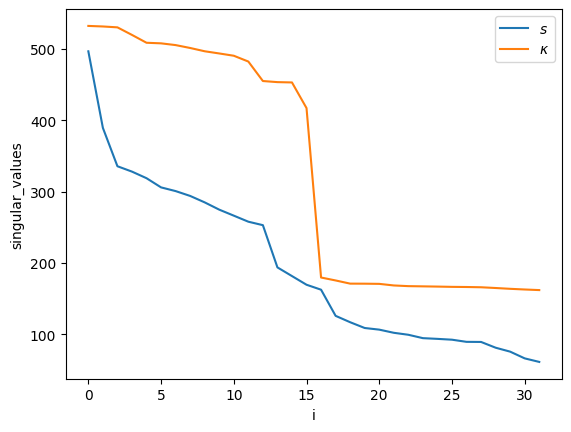

In [64]:
plt.plot(s_AS2.cpu().numpy(),label = '$s$')
plt.plot(s_S2.cpu().numpy(),label = '$\kappa$')
plt.xlabel('i')
plt.ylabel('singular_values')
plt.legend()

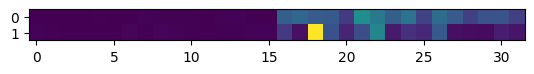

In [56]:
plt.imshow(abs(W.cpu().numpy()))

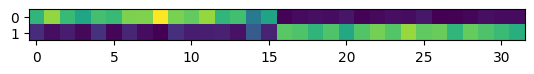

In [8]:
A = np.load('../results/jacobian/long_term_forecast_Kuramoto_NN_Kuramoto_ft-1_sl1_pl1_dm128_nh8_el2_dl1_df2048_fc1_flocnormal_dtTrue_Exp_0/jac_1110.npy')
L = np.load('../results/cov_L/long_term_forecast_Kuramoto_NN_Kuramoto_ft-1_sl1_pl1_dm128_nh8_el2_dl1_df2048_fc1_flocnormal_dtTrue_Exp_0/L_1110.npy')

n = A.shape[0]
L_diag = np.diag(L)
Sigma = L_diag
Sigma_inv_b = A.T @ np.linalg.inv(Sigma) @ A
Sigma_inv_f = np.linalg.inv(Sigma)
Sigma_inv_b_tensor = torch.tensor(Sigma_inv_b,device=device)
Sigma_inv_f_tensor = torch.tensor(Sigma_inv_f,device=device)

U, s_AS2, _ = torch.svd(Sigma_inv_b_tensor)
# Perform SVD on Sigma^-1
V, s_S2, _ = torch.svd(Sigma_inv_f_tensor)

plt.imshow(abs(U[:,:2].T.cpu().numpy()))

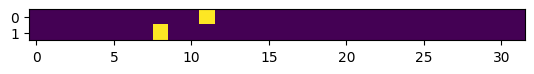

In [9]:
plt.imshow(abs(V[:,:2].T.cpu().numpy()))